In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.conv5 = nn.Conv2d(256, 512, 3)
#         self.conv6 = nn.Conv2d(512, 1024, 3)
#         self.conv7 = nn.Conv2d(1024, 10, 3)

#     def forward(self, x):
#         x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
#         x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
#         x = F.relu(self.conv6(F.relu(self.conv5(x))))
#         # x = F.relu(self.conv7(x))
#         x = self.conv7(x)
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)

In [0]:
# !pip install torchsummary
# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# model = Net().to(device)
# summary(model, input_size=(1, 28, 28))

The above model has 6.3 million parameters. It is quiet a heavy model. 

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 24, RF = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 22, RF = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11, RF = 8
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 11, RF = 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 9, RF = 12
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7, RF = 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7, RF = 20
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 20

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 500)
        return F.log_softmax(x, dim=-1)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800
             ReLU-13             [-1, 20, 7, 7]               0
           Conv2d-14             [-1, 2

The above model is less than 10k parameters

In [10]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


loss=1.5432969331741333 batch_id=468 Accuracy=28.36: 100%|██████████| 469/469 [00:11<00:00, 42.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3558, Accuracy: 5739/10000 (57%)

EPOCH: 1


loss=1.0323081016540527 batch_id=468 Accuracy=61.52: 100%|██████████| 469/469 [00:10<00:00, 44.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0037, Accuracy: 6815/10000 (68%)

EPOCH: 2


loss=0.8838438391685486 batch_id=468 Accuracy=70.72: 100%|██████████| 469/469 [00:10<00:00, 44.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9357, Accuracy: 6908/10000 (69%)

EPOCH: 3


loss=0.7629485130310059 batch_id=468 Accuracy=75.49: 100%|██████████| 469/469 [00:10<00:00, 45.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6671, Accuracy: 7898/10000 (79%)

EPOCH: 4


loss=0.5127052068710327 batch_id=468 Accuracy=78.54: 100%|██████████| 469/469 [00:10<00:00, 45.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6093, Accuracy: 8093/10000 (81%)

EPOCH: 5


loss=0.49227479100227356 batch_id=468 Accuracy=80.42: 100%|██████████| 469/469 [00:10<00:00, 45.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5891, Accuracy: 8076/10000 (81%)

EPOCH: 6


loss=0.5710516571998596 batch_id=468 Accuracy=81.72: 100%|██████████| 469/469 [00:10<00:00, 44.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5688, Accuracy: 8137/10000 (81%)

EPOCH: 7


loss=0.3363877236843109 batch_id=468 Accuracy=83.22: 100%|██████████| 469/469 [00:10<00:00, 44.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5068, Accuracy: 8410/10000 (84%)

EPOCH: 8


loss=0.4567858874797821 batch_id=468 Accuracy=84.56: 100%|██████████| 469/469 [00:10<00:00, 44.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4900, Accuracy: 8464/10000 (85%)

EPOCH: 9


loss=0.3813502788543701 batch_id=468 Accuracy=85.44: 100%|██████████| 469/469 [00:10<00:00, 45.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4591, Accuracy: 8598/10000 (86%)

EPOCH: 10


loss=0.6476354002952576 batch_id=468 Accuracy=85.83: 100%|██████████| 469/469 [00:10<00:00, 44.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4476, Accuracy: 8565/10000 (86%)

EPOCH: 11


loss=0.5509100556373596 batch_id=468 Accuracy=86.62: 100%|██████████| 469/469 [00:10<00:00, 45.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4584, Accuracy: 8516/10000 (85%)

EPOCH: 12


loss=0.31423795223236084 batch_id=468 Accuracy=87.01: 100%|██████████| 469/469 [00:10<00:00, 45.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4024, Accuracy: 8767/10000 (88%)

EPOCH: 13


loss=0.30457714200019836 batch_id=468 Accuracy=87.53: 100%|██████████| 469/469 [00:10<00:00, 44.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3994, Accuracy: 8715/10000 (87%)

EPOCH: 14


loss=0.14878250658512115 batch_id=468 Accuracy=87.97: 100%|██████████| 469/469 [00:10<00:00, 44.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4133, Accuracy: 8714/10000 (87%)

EPOCH: 15


loss=0.3249307870864868 batch_id=468 Accuracy=88.20: 100%|██████████| 469/469 [00:10<00:00, 44.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4069, Accuracy: 8725/10000 (87%)

EPOCH: 16


loss=0.2471688836812973 batch_id=468 Accuracy=88.36: 100%|██████████| 469/469 [00:10<00:00, 44.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3901, Accuracy: 8755/10000 (88%)

EPOCH: 17


loss=0.34587493538856506 batch_id=468 Accuracy=88.94: 100%|██████████| 469/469 [00:10<00:00, 44.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4053, Accuracy: 8786/10000 (88%)

EPOCH: 18


loss=0.3026939332485199 batch_id=468 Accuracy=89.09: 100%|██████████| 469/469 [00:10<00:00, 44.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3460, Accuracy: 8946/10000 (89%)

EPOCH: 19


loss=0.44630858302116394 batch_id=468 Accuracy=89.42: 100%|██████████| 469/469 [00:10<00:00, 45.16it/s]



Test set: Average loss: 0.3725, Accuracy: 8858/10000 (89%)



Target: To make the model light-weight by bringing the number of parameters     to less than or equal to 10,000

Result: Achieved the number of parameters by bringing it down to 9,690.

Analysis: The training accuracy is around 89% while the test accuracy is around 88%.
The accuracy over the first 5 epochs needs to be improvised by fine-tuning the model.
The model is not learning much from the 13th epoch.


Text(0.5, 1.0, 'Test Accuracy')

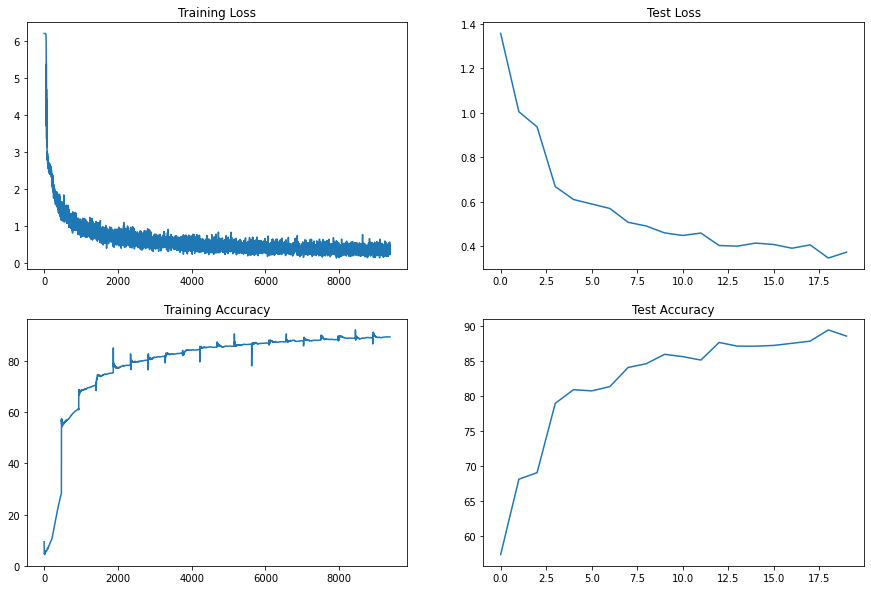

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")